## Imports and Data

We will be working with the 20 newsgroups dataset.

I have included the minimal sufficient imports to complete the coursework. You are welcome to import other modules.

**some functions will produce sparse matrices for which operations may not work as you expect. Make sure to check the dimensionality of your outputs. You should be able to convert to normal arrays with .toarray() if you have any problems**

**This coursework follows the Kernels for text section in the slides**

In [19]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'), subset='train', categories=['sci.electronics','rec.autos','rec.sport.hockey'])
train_documents = dataset.data
train_targets=dataset.target
train_target_names=dataset.target_names
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'), subset='test', categories=['sci.electronics','rec.autos','rec.sport.hockey'])
test_documents = dataset.data
test_targets=dataset.target
test_target_names=dataset.target_names

## 1) Using CountVectorizer or otherwise, convert the list of documents to

### a) Use CountVectorizer to get the counts of each term (word) in each of the documents

In [20]:
def term_frequencies(corpus_train, corpus_test):
    count_vectorizer = CountVectorizer()
    tf_train = count_vectorizer.fit_transform(corpus_train)
    tf_test = count_vectorizer.transform(corpus_test)
    return tf_train, tf_test

### b) Write a function which returns the document frequency of each of the terms across all of the training documents. Use np.asarray() and np.squeeze() to ensure this produces a 1d output

In [21]:
def document_frequencies(corpus_train, corpus_test):
    tf_train, tf_test = term_frequencies(corpus_train, corpus_test)

    #sum over all documents
    df_train = np.squeeze(np.asarray(tf_train.sum(axis=0)))
    df_test = np.squeeze(np.asarray(tf_test.sum(axis=0)))

    return df_train, df_test

### c) Using numpy.histogram followed by plt.hist, plot a histogram of the log of the document frequencies

(0.0, 13211.0)

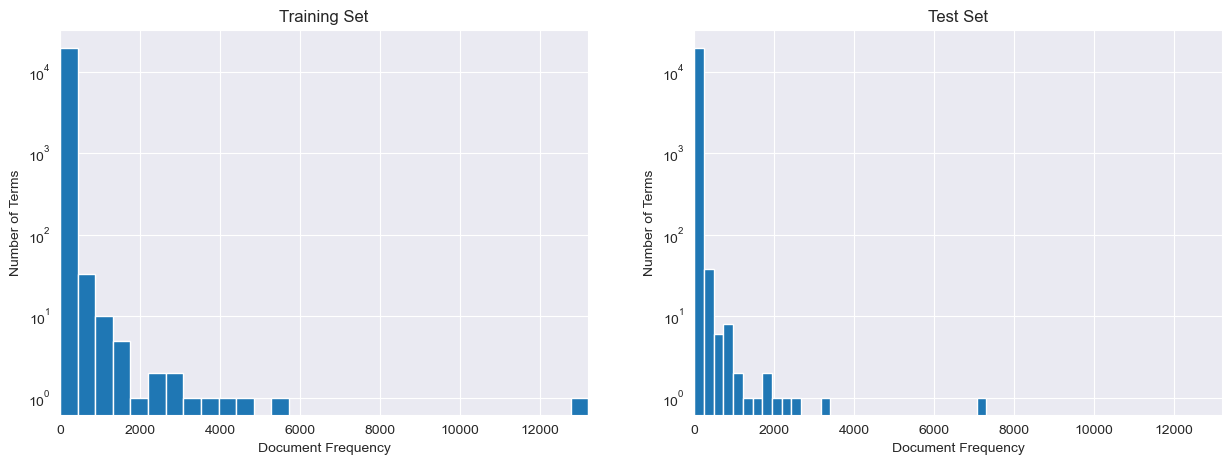

In [22]:
df_train, df_test = document_frequencies(train_documents, test_documents)

n_bins = 30

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(df_train, bins = n_bins)
plt.xlabel("Document Frequency")
plt.ylabel("Number of Terms")
plt.yscale("log")
plt.title("Training Set")
plt.xlim(0, max(df_train))

plt.subplot(122)
plt.hist(df_test, bins = n_bins)
plt.title("Test Set")
plt.xlabel("Document Frequency")
plt.ylabel("Number of Terms")
plt.yscale("log")
plt.xlim(0, max(df_train))

### e) Write a function which returns the inverse document frequency

In [23]:
# converting vector to diagonal matrix
def diagonalize(vector):
    n_terms = len(vector)
    matrix = np.zeros((n_terms, n_terms), np.float16)
    np.fill_diagonal(matrix, vector)
    return matrix

def inverse_document_frequencies(corpus_train, corpus_test):
    N_train = len(corpus_train)
    N_test = len(corpus_test)

    df_train, df_test = document_frequencies(corpus_train, corpus_test)

    inverter = lambda df: np.log(N_train/df)
    idf_train = inverter(df_train)
    idf_train = diagonalize(idf_train)

    inverter = lambda df: np.log(N_test/df)
    idf_test = inverter(df_test)
    idf_test = diagonalize(idf_test)

    return idf_train, idf_test

### f) Write a function which returns the tfidf weighted kernel for two sets of documents (i.e. train and test)

In [24]:
def tfidf_kernel(corpus_train, corpus_test):
    idf_train, idf_test = inverse_document_frequencies(corpus_train, corpus_test)
    tf_train, tf_test = term_frequencies(corpus_train, corpus_test)

    tfidf_train = tf_train @ idf_train**2 @ tf_train.transpose()
    tfidf_test = tf_test @ idf_test**2 @ tf_test.transpose()

    return tfidf_train, tfidf_test

### g) Use an SVC classifier with the outputs of CountVectorizer (ie the term counts for each document) to classify the documents according to the train_targets and test_targets and present the performance of this classifier in a suitable way.

The Training accuracy is:  0.70
The Test accuracy is:  0.64


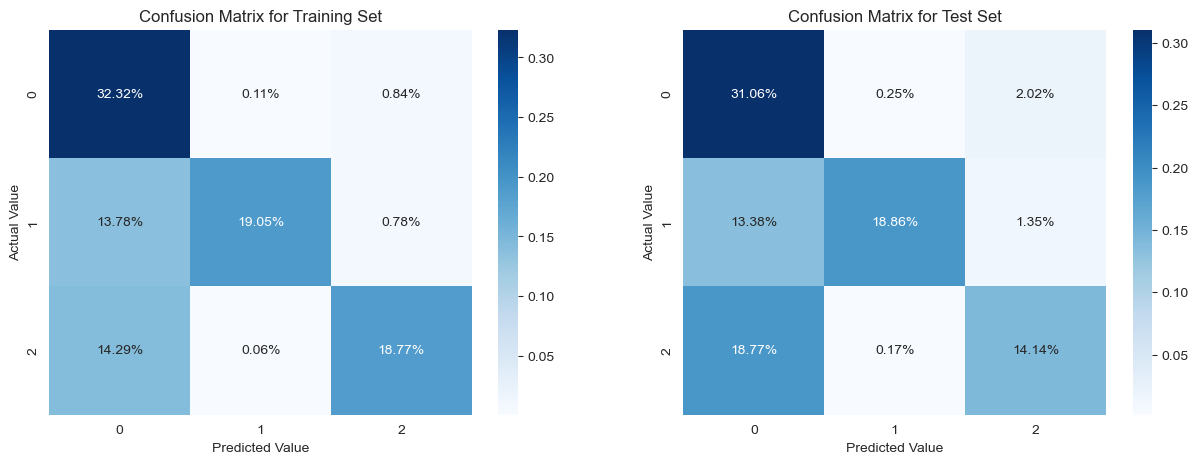

In [25]:
from sklearn import metrics
import seaborn as sns
tf_train, tf_test = term_frequencies(train_documents, test_documents)

svc = SVC()
svc.fit(tf_train, train_targets)

def show_metrics(predicted, true, label="Test"):
    accuracy = metrics.accuracy_score(true, predicted)
    print(f"The {label} accuracy is: {accuracy : .2f}")

    cm = metrics.confusion_matrix(true, predicted)
    sns.heatmap(cm/np.sum(cm), annot=True,
                fmt='.2%', cmap='Blues')
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    plt.title(f"Confusion Matrix for {label} Set")

plt.figure(figsize=(15,5))
plt.subplot(121)
train_pred = svc.predict(tf_train)
show_metrics(train_pred, train_targets, "Training")

plt.subplot(122)
test_pred = svc.predict(tf_test)
show_metrics(test_pred, test_targets, "Test")

### h) Construct the tfidf kernel for the train (n_train x n_train) and test (n_test x n_train) data

In [26]:
tfidf_train, tfidf_test = tfidf_kernel(train_documents, test_documents)

C:\Users\david\AppData\Local\Temp\ipykernel_3480\2875171923.py:18: RuntimeWarning: divide by zero encountered in true_divide
  inverter = lambda df: np.log(N_test/df)


In [33]:
print(tfidf_train.shape)
print(tfidf_test.shape)

(1785, 1785)
(1188, 1188)


### i) use the SVC classifier again to classify the documents. Compare the performance to the previous case

In [32]:
svc = SVC(kernel=tfidf_train)
svc.fit(tf_train, train_targets)

plt.figure(figsize=(15,5))
plt.subplot(121)
train_pred = svc.predict(tf_train)
show_metrics(train_pred, train_targets, "Training")

plt.subplot(122)
test_pred = svc.predict(tf_test)
show_metrics(test_pred, test_targets, "Test")

C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:159: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sparse and self.kernel == "precomputed":
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:197: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.kernel == "precomputed" and n_samples != X.shape[1]:
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kernel == "precomputed":
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kernel_type = self._sparse_kernels.index(kernel

ValueError: array([[1.09708942e+03, 1.70654907e+02, 1.33466797e+01, ...,
        3.94492188e+01, 2.25892517e+02, 1.80920410e+01],
       [1.70654907e+02, 7.38693915e+03, 4.23511353e+01, ...,
        1.46731140e+02, 7.28235291e+02, 9.79943848e+01],
       [1.33466797e+01, 4.23511353e+01, 1.76199829e+02, ...,
        2.16901245e+01, 8.01604614e+01, 2.71289062e+00],
       ...,
       [3.94492188e+01, 1.46731140e+02, 2.16901245e+01, ...,
        2.63933783e+03, 2.30037235e+02, 2.64648438e+00],
       [2.25892517e+02, 7.28235291e+02, 8.01604614e+01, ...,
        2.30037235e+02, 4.12192109e+03, 4.70285645e+01],
       [1.80920410e+01, 9.79943848e+01, 2.71289062e+00, ...,
        2.64648438e+00, 4.70285645e+01, 8.91341235e+03]]) is not in list

### j) Extension: Use (Kernel/Linear) PCA with varying dimensions of your tfidf kernel and repeat the classification or explore the eigenvalues of the kernel PCA and comment.

In [28]:
#YOUR CODE HERE